In [1]:
import copy

from catboost import CatBoostClassifier
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader as GraphDataLoader
from sklearn.metrics import mean_squared_error

import src.utils as utils
from src.dataset import (
    create_synthetic_target,
    create_synthetic_dataset,
    load_cyp_data_split,
    load_herg_data_split,
    load_synthetic_data_split
)
from src.featurizers import ECFPFeaturizer, GraphFeaturizer
from src.splitters import ScaffoldSplitter
from src.models.gnn import GraphConvolutionalNetwork
from src.early_stopping import EarlyStopping
from src.explanations import (
    abs_feature_importance_and_lime_difference,
    get_dataframe_from_lime_results,
    get_connected_components_for_explanation,
    generate_lime_explanations,
    plot_grad_cam_explanation,
    plot_saliency_map_explanation,
    saliency_map,
    grad_cam
)
from src.utils import get_morgan_fragment, load_gnn_model, load_catboost_model
from tuning_results import synthetic_catboost_params, herg_catboost_params, cyp_catboost_params

seed = 1
np.random.seed(seed)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\kamil\miniconda3\envs\masters\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
train, _, test = load_synthetic_data_split()

fp_size = 2048
fp_radius = 2
featurizer = ECFPFeaturizer("y", length=fp_size, radius=fp_radius, log_target_transform=False)
X_train, y_train = featurizer(train)
X_test, y_test = featurizer(test)

[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerator
[08:53:17] DEPRECATION WARNING: please use MorganGenerat

### Testing LIME on synthetic data

In [3]:
model = CatBoostClassifier(
    iterations=9999,
    learning_rate=synthetic_catboost_params["lr"],
    max_depth=synthetic_catboost_params["max_depth"],
    l2_leaf_reg=synthetic_catboost_params["l2_leaf_reg"],
)
model = model.load_model("models/catboost_tuned_synthetic.cbm")

In [5]:
mols_to_check = np.random.choice(len(X_test), 5)
X_test_to_check = X_test[mols_to_check]

n_trials = 50
results = []
for trial in range(n_trials):
    results.append(generate_lime_explanations(X_train, model, X_test_to_check))
results = np.array(results)

In [12]:
bits_found_by_lime = set()
for i in range(len(results)):
    for j in range(len(results[i])):
        for k in range(len(results[j])):
            bits_found_by_lime.add(results[i][j][k][0])

bits_found_in_each_mol = []
bits_coefficients = []
for i in range(len(results[0])):
    bits_found_in_each_mol.append(results[:, i, :, 0].flatten())
    bits_coefficients.append(results[:, i, :, 1].flatten())

The top bit (1750), according to feature attribution, is found for each molecule tested. This is promising and warrants testing on real datasets. I suspect, however, that this is due to the fact that the task posed in the synthetic data is easy.

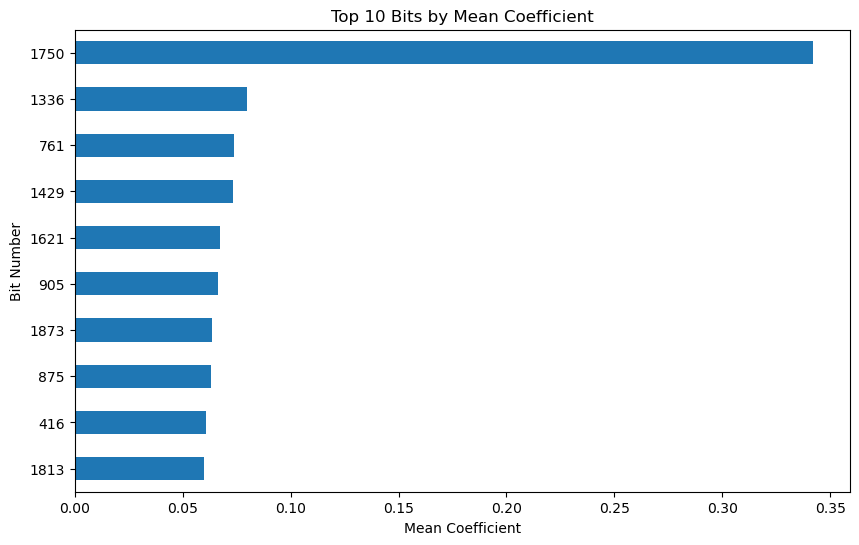

In [67]:
individual_results = []

for i in range(len(bits_found_in_each_mol)):
    lime_results = pd.DataFrame(data={"bit_number": bits_found_in_each_mol[i], "coefficient": bits_coefficients[i]})
    lime_results.loc[:, "bit_number"] = lime_results["bit_number"].astype(int)
    lime_results.loc[:, "coefficient"] = lime_results["coefficient"].astype(float)
    lime_results = lime_results.assign(mean=lime_results.groupby("bit_number")["coefficient"].transform("mean"))
    individual_results.append(lime_results)
aggregated_mean_lime_coef = pd.concat(individual_results)

top_10_bits = aggregated_mean_lime_coef.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(10)
top_10_bits.index = top_10_bits.index.astype("object")

plt.figure(figsize=(10, 6))
top_10_bits.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Bits by Mean Coefficient')
plt.xlabel('Mean Coefficient')
plt.ylabel('Bit Number')
plt.show()

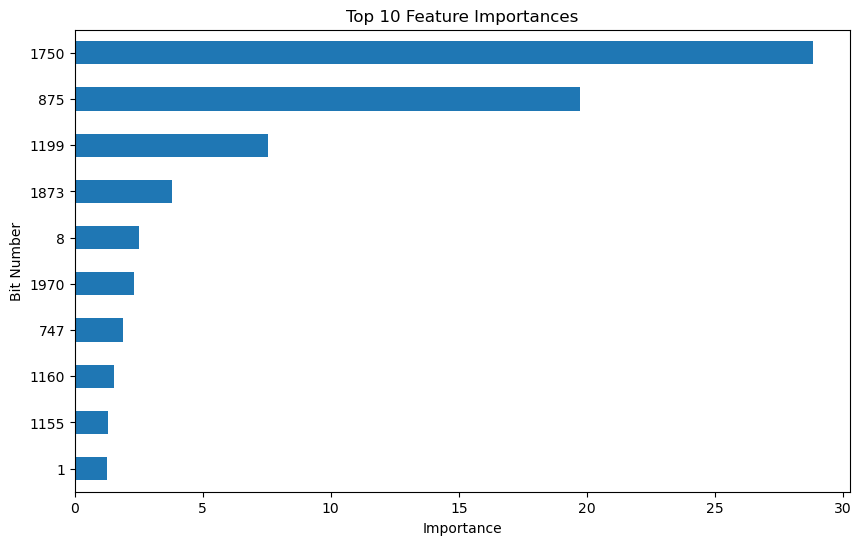

In [68]:
feature_importances = model.get_feature_importance(prettified=True).head(10)
feature_importances = feature_importances.rename(columns={"Feature Id": "bit_number", "Importances": "importance"})

plt.figure(figsize=(10, 6))
feature_importances.set_index('bit_number')['importance'].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Bit Number')
plt.show()

[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator
[13:40:02] DEPRECATION WARNING: please use MorganGenerator


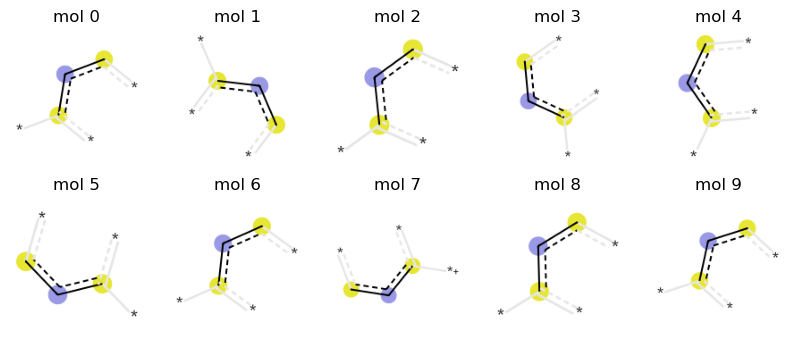

In [69]:
utils.draw_morgan_bit_many_molecules(train, 1750, fp_radius, fp_size)

In [ ]:
abs_feature_importance_and_lime_difference(feature_importances, top_10_bits)

0.261487887783807

### Testing LIME on real datasets

We will approximate the global effect of bits by sampling a set number of molecules, running LIME on each of them, and averaging the results. Then, we will compare said results to feature importance scores.

In [4]:
def test_lime_vs_feature_importance(train_data, test_data, dataset_name, best_params, n_molecules: int = 50):
    X_train, _ = featurizer(train_data)
    X_test, _ = featurizer(test_data)
    model = load_catboost_model(dataset_name, best_params)
    test_molecules_to_check = X_test[np.random.choice(len(X_test), n_molecules)]
    lime_results = get_dataframe_from_lime_results(generate_lime_explanations(X_train, model, test_molecules_to_check))
    top_10_lime_bits = lime_results.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(10)
    feature_importances = model.get_feature_importance(prettified=True).head(10)
    feature_importances = feature_importances.rename(columns={"Feature Id": "bit_number", "Importances": "importance"})
    return abs_feature_importance_and_lime_difference(feature_importances, top_10_lime_bits)

In [5]:
best_params = cyp_catboost_params
dataset_name = "cyp"
train, _, test = load_cyp_data_split()
cyp_result = test_lime_vs_feature_importance(train, test, dataset_name, best_params, n_molecules=50)

best_params = herg_catboost_params
dataset_name = "herg"
train, _, test = load_herg_data_split()
herg_result = test_lime_vs_feature_importance(train, test, dataset_name, best_params, n_molecules=50)

best_params = synthetic_catboost_params
dataset_name = "synthetic"
train, _, test = load_synthetic_data_split()
synthetic_result = test_lime_vs_feature_importance(train, test, dataset_name, best_params, n_molecules=50)

Found local copy...
Loading...
Done!
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECATION WARNING: please use MorganGenerator
[08:53:33] DEPRECAT

Assuming both methods found the same bits, the expected difference is 1/3 if the scores were random.\
Here, the result is higher due to different bits being found, and so in those cases the comparison is between 0 and x, where x is the score for this bit in the other method.\
Anyway, these are poor scores.

In [6]:
herg_result

0.37315615661094204

In [7]:
cyp_result

0.5171477886000302

In [8]:
synthetic_result

0.19227612337989802

### Training on only top bits vs random bits

In [26]:
def get_fingerprint_with_zeroed_top_bits(X, top_bits):
    X_inverted = copy.deepcopy(X)
    X_inverted[:, top_bits] = 0
    return X_inverted


X_zeroed = get_fingerprint_with_zeroed_top_bits(X, top_feature_values[:10])
X_zeroed_train, X_zeroed_test, _, _ = scaffold_splitter.train_test_split(X_zeroed, y, data_smiles)

model_zeroed = CatBoostClassifier(iterations=9999, learning_rate=0.05, max_depth=5,
                           random_state=seed, verbose=100)
model_zeroed.fit(X_zeroed_train, y_train, eval_set=(X_zeroed_test, y_test), early_stopping_rounds=100)
model_zeroed.score(X_zeroed_train, y_train), model_zeroed.score(X_zeroed_test, y_test), mean_squared_error(y_test, model_zeroed.predict(X_test))

0:	learn: 0.6456573	test: 0.6467645	best: 0.6467645 (0)	total: 8.27ms	remaining: 1m 22s
100:	learn: 0.1621726	test: 0.1915704	best: 0.1915704 (100)	total: 1.21s	remaining: 1m 58s
200:	learn: 0.1196888	test: 0.1565996	best: 0.1565996 (200)	total: 2.5s	remaining: 2m 2s
300:	learn: 0.0946427	test: 0.1411091	best: 0.1411091 (300)	total: 3.79s	remaining: 2m 2s
400:	learn: 0.0785080	test: 0.1320049	best: 0.1320049 (400)	total: 4.99s	remaining: 1m 59s
500:	learn: 0.0664027	test: 0.1246362	best: 0.1246362 (500)	total: 6.21s	remaining: 1m 57s
600:	learn: 0.0569627	test: 0.1195122	best: 0.1195122 (600)	total: 7.33s	remaining: 1m 54s
700:	learn: 0.0493042	test: 0.1150178	best: 0.1150178 (700)	total: 8.52s	remaining: 1m 53s
800:	learn: 0.0433286	test: 0.1118930	best: 0.1118930 (800)	total: 9.77s	remaining: 1m 52s
900:	learn: 0.0385149	test: 0.1097694	best: 0.1097694 (900)	total: 11s	remaining: 1m 51s
1000:	learn: 0.0342710	test: 0.1077701	best: 0.1077701 (1000)	total: 12.3s	remaining: 1m 50s
1100:

(1.0, 0.962, 0.038)

In [33]:
top_feature_values_zeroed = np.argsort(model_zeroed.feature_importances_)[::-1]
top_feature_values_zeroed[:10]

array([1088, 1873, 1536, 1160,  718,  191,  389,  699, 1754, 1097],
      dtype=int64)

In [29]:
model_zeroed.feature_importances_[top_feature_values_zeroed][:10]

array([7.72156451, 5.93436975, 3.64789926, 3.45383811, 3.21685288,
       3.16085966, 2.64052951, 2.35273556, 1.7742161 , 1.54562963])

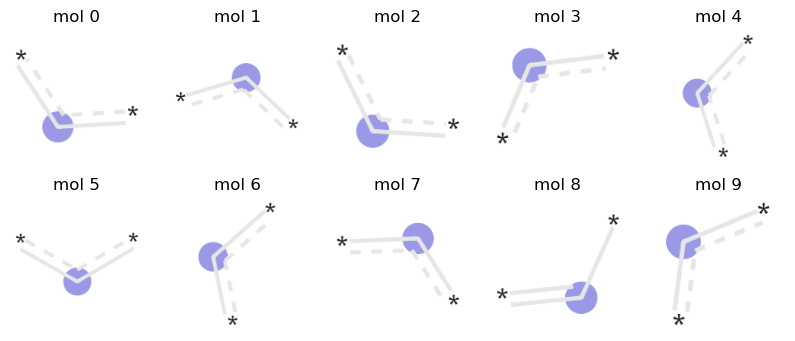

In [44]:
utils.draw_morgan_bit_many_molecules(data, 1873, fp_radius, fp_size)

In [ ]:
# repeat with random 10 fingerprint bits

X_top = X[:, top_feature_values[:10]]
X_top_train, X_top_test, _, _ = scaffold_splitter.train_test_split(X_top, y, data_smiles)

model_top = CatBoostClassifier(iterations=9999, learning_rate=0.01, max_depth=5,
                            random_state=seed, verbose=100)
model_top.fit(X_top_train, y_train, eval_set=(X_top_test, y_test), early_stopping_rounds=100)
model_top.score(X_top_train, y_train), model_top.score(X_top_test, y_test), mean_squared_error(y_test, model_top.predict(X_top_test))

0:	learn: 0.6762026	test: 0.6769028	best: 0.6769028 (0)	total: 6.59ms	remaining: 1m 5s
100:	learn: 0.1719423	test: 0.1883563	best: 0.1883563 (100)	total: 302ms	remaining: 29.6s
200:	learn: 0.1352226	test: 0.1527350	best: 0.1527350 (200)	total: 562ms	remaining: 27.4s
300:	learn: 0.1265945	test: 0.1440217	best: 0.1440217 (300)	total: 837ms	remaining: 27s
400:	learn: 0.1234587	test: 0.1407253	best: 0.1407253 (400)	total: 1.1s	remaining: 26.3s
500:	learn: 0.1219307	test: 0.1393001	best: 0.1393001 (500)	total: 1.35s	remaining: 25.6s
600:	learn: 0.1210892	test: 0.1385881	best: 0.1385881 (600)	total: 1.59s	remaining: 24.9s
700:	learn: 0.1205674	test: 0.1381998	best: 0.1381998 (700)	total: 1.83s	remaining: 24.3s
800:	learn: 0.1201451	test: 0.1380475	best: 0.1380393 (798)	total: 2.08s	remaining: 23.9s
900:	learn: 0.1197628	test: 0.1379759	best: 0.1379751 (892)	total: 2.33s	remaining: 23.5s
1000:	learn: 0.1194603	test: 0.1380510	best: 0.1379561 (919)	total: 2.56s	remaining: 23.1s
Stopped by over

(0.952125, 0.9445, 0.0555)